# Surface concentrations

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from datetime import date

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# model results:
year = 2002
base_old    = '/data/brogalla/run_storage/Mn-set4-202004/'
base_tuning = '/data/brogalla/run_storage/Mn-tuning-202012/'
old_10    = base_old + 'ref-spin-up0/'

In [4]:
stn_i = np.array([104-1, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547, 629])
stn_j = np.array([370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])
stn_n = np.array(['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7',
                  'CAA8','CAA9', 'CB1','CB2','CB3','CB4'])

In [5]:
c = ['#f28327','#fffc4c','#adea32','#16ec83','#0087db','#00375d', '#7b68ee']

In [6]:
month=7
i1  = 608; j1  = 418; # Canada Basin
i2  = 528; j2  = 190; # Amundsen Gulf
i3  = 198; j3  = 140; # South central
i4  = 80 ; j4  = 200; # Gulf of Boothia

###### Load files:

In [7]:
ref   = nc.Dataset(old_10+'ANHA12_EXH006_'+str(year)+'_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [8]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t

##### Functions:

In [9]:
def load_data(spin_up, old=False, tuning1=False, tuning2=False, tuning3=False, tuning4=False):    
    dissolmn = np.empty((spin_up,12,50,700,640))
    oxidismn = np.empty((spin_up,12,50,700,640))
    
    for i in range(0,spin_up):
        if old:
            folder = base_old + 'ref-spin-up' + str(i) +'/'
        elif tuning1:
            folder = base_tuning + 'spin-up' + str(i) +'-tuning1/'
        elif tuning2:
            folder = base_tuning + 'spin-up' + str(i) +'-tuning2/'
        elif tuning3:
            folder = base_tuning + 'spin-up' + str(i) +'-tuning3/'
        elif tuning4:
            folder = base_tuning + 'spin-up' + str(i) +'-tuning4/'
    dissolmn[i,:,:,:,:] = np.array(results.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
    oxidismn[i,:,:,:,:] = np.array(results.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units
    results.close()
    
    return dissolmn, oxidismn

In [10]:
def plot_layer(month, variable, vmin=0,vmax=35):
    
    plot_var = np.mean(variable[month,1:17,:,:], axis=0)
#     plot_var = variable[month,0,:,:]
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

    x, y = proj1(lons, lats)

    contour = proj1.contourf(x, y, plot_var, np.arange(vmin,vmax+1,2.5),\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')

    cbar_ax = fig.add_axes([0.72, 0.14, 0.04, 0.6])
    cbar    = fig.colorbar(contour, cax=cbar_ax, ticks=np.arange(0,35,5))#[0,2,4,6,8,10,12])
    cbar.set_label('Dissolved Mn [nM]', fontsize=8) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=8)
    
    figure = plt.gcf()
    figure.set_size_inches(4.5*1.8, 3.7)
    
    ax1.plot(x[i1,j1], y[i1,j1], '.r', markersize=10, zorder=5)
    ax1.plot(x[i2,j2], y[i2,j2], '.b', markersize=10, zorder=5)
    ax1.plot(x[i3,j3], y[i3,j3], '.b', markersize=10, zorder=5)
    ax1.plot(x[i4,j4], y[i4,j4], '.b', markersize=10, zorder=5)
    return

In [11]:
def plot_profiles(dmn, title):    
    
    fig, ax = plt.subplots(1,4, figsize=(10,4))

    for axes in ax.flatten():
        axes.invert_yaxis()
        axes.tick_params(axis='both', labelsize=10)
        axes.xaxis.tick_top()    
        axes.xaxis.set_label_position('top') 
        axes.set_xlim(0,20)

    spinups = dmn.shape[0]
    for spin in range(0,spinups):
        ax[0].plot(dmn[spin,month,:,i1,j1], depth, '-', color=c[spin])
        ax[1].plot(dmn[spin,month,:,i2,j2], depth, '-', color=c[spin])
        ax[2].plot(dmn[spin,month,:,i3,j3], depth, '-', color=c[spin])
        ax[3].plot(dmn[spin,month,:,i4,j4], depth, '-', color=c[spin])
        
        ax[0].set_title('Canada Basin: '+str(title), fontsize=11)
        ax[1].set_title('Amundsen Gulf: '+str(title), fontsize=11)
        ax[2].set_title('South Central: '+str(title), fontsize=11)
        ax[3].set_title('Gulf of Boothia: '+str(title), fontsize=11)

    ax[0].set_ylim(4000,-100)
    ax[1].set_ylim(500,-10)
    ax[2].set_ylim(150,-10)
    ax[3].set_ylim(150,-10)
    ax[3].set_xlim(0,35)

    ax[0].set_ylabel('Depth [m]', fontsize=11)
    
    return

In [12]:
def plot_stations(dmn):    
    
    fig, ax = plt.subplots(3,5, figsize=(11,7))

    for axes in ax.flatten():
        axes.invert_yaxis()
        axes.tick_params(axis='both', labelsize=10)
        axes.xaxis.tick_top()    
        axes.xaxis.set_label_position('top') 
        axes.set_xlim(0,10)

    spinups = dmn.shape[0]
    for stn in range(0,len(stn_n)):
        # Plot spin up model results
        for spin in range(0,spinups):
            if stn < 5:
                ax[0,stn].plot(dmn[spin,month,:,stn_i[stn],stn_j[stn]], depth, '-', color=c[spin])
                ax[0,stn].set_title(stn_n[stn], fontsize=11)
                ax[0,stn].set_ylim(1000,0)
            elif (stn > 4) & (stn < 10):
                ax[1,stn-5].plot(dmn[spin,month,:,stn_i[stn],stn_j[stn]], depth, '-', color=c[spin])
                ax[1,stn-5].set_title(stn_n[stn], fontsize=11)
                ax[1,stn-5].set_ylim(1000,0)
            else:
                ax[2,stn-10].plot(dmn[spin,month,:,stn_i[stn],stn_j[stn]], depth, '-', color=c[spin])
                ax[2,stn-10].set_title(stn_n[stn], fontsize=11)
                ax[2,stn-10].set_ylim(4000,0)

#         # Plot observations
#         if stn < 5:
#             ax[0,stn].plot(dmn[spin,month,:,stn_i[stn],stn_j[stn]], depth, '--k')
#         elif (stn > 4) & (stn < 10):
#             ax[1,stn].plot(dmn[spin,month,:,stn_i[stn],stn_j[stn]], depth, '--k')
#         else:
#             ax[2,stn].plot(dmn[spin,month,:,stn_i[stn],stn_j[stn]], depth, '--k')
            
#     ax[0].set_ylim(4000,-100)
#     ax[1].set_ylim(500,-10)
#     ax[2].set_ylim(150,-10)
#     ax[3].set_ylim(150,-10)
#     ax[3].set_xlim(0,35)

    ax[0,0].set_ylabel('Depth [m]', fontsize=11)
    
    return

<IPython.core.display.Javascript object>


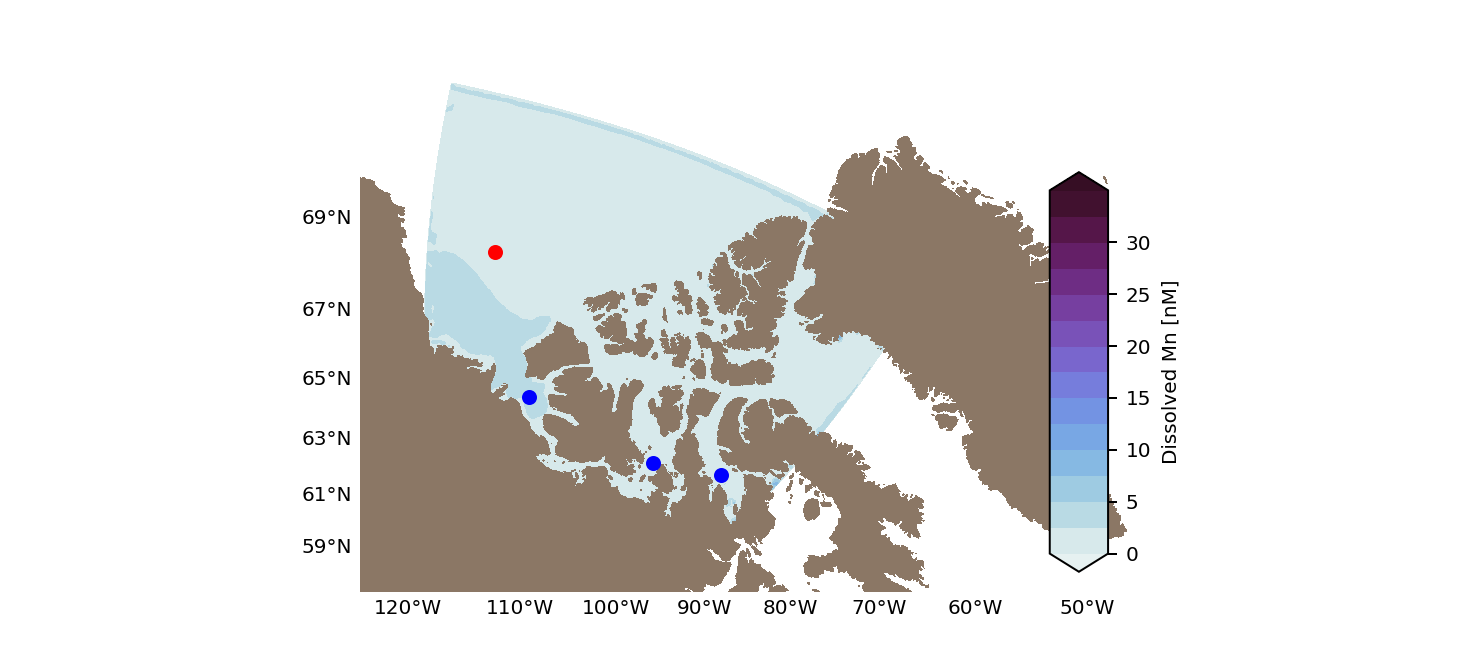

In [20]:
plot_layer(0, dissolmn1)

###### Check whether the profiles are spinning up at certain test locations:

In [13]:
dmn_old    , omn_old     = load_data(7, old=True)
dmn_tuning1, omn_tuning1 = load_data(4, tuning1=True)
dmn_tuning2, omn_tuning2 = load_data(7, tuning2=True)
dmn_tuning3, omn_tuning3 = load_data(7, tuning3=True)
dmn_tuning4, omn_tuning4 = load_data(5, tuning4=True)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


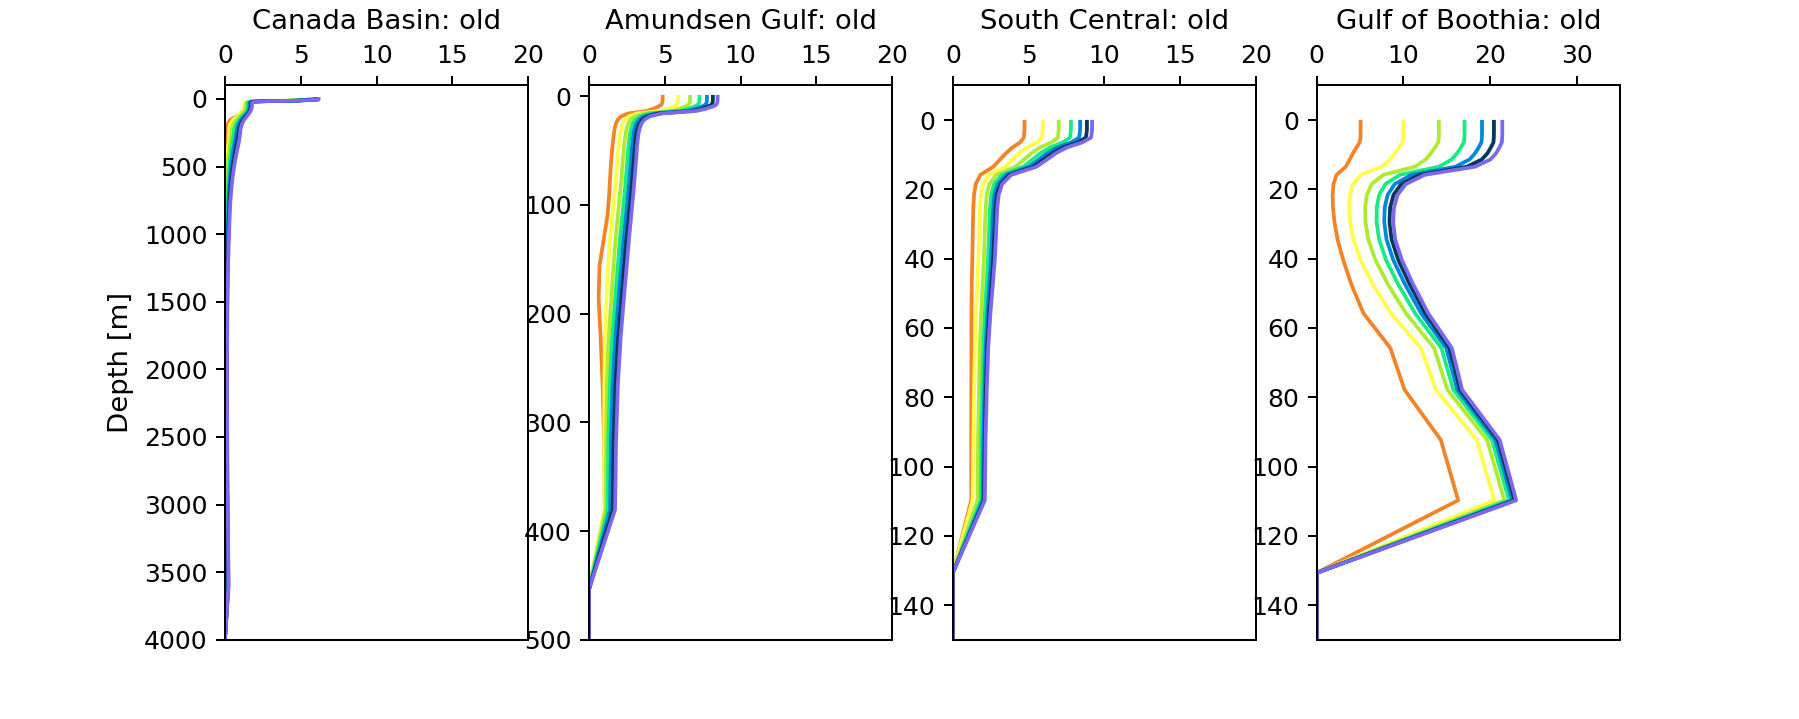

In [63]:
plot_profiles(dmn_old, 'old')

<IPython.core.display.Javascript object>


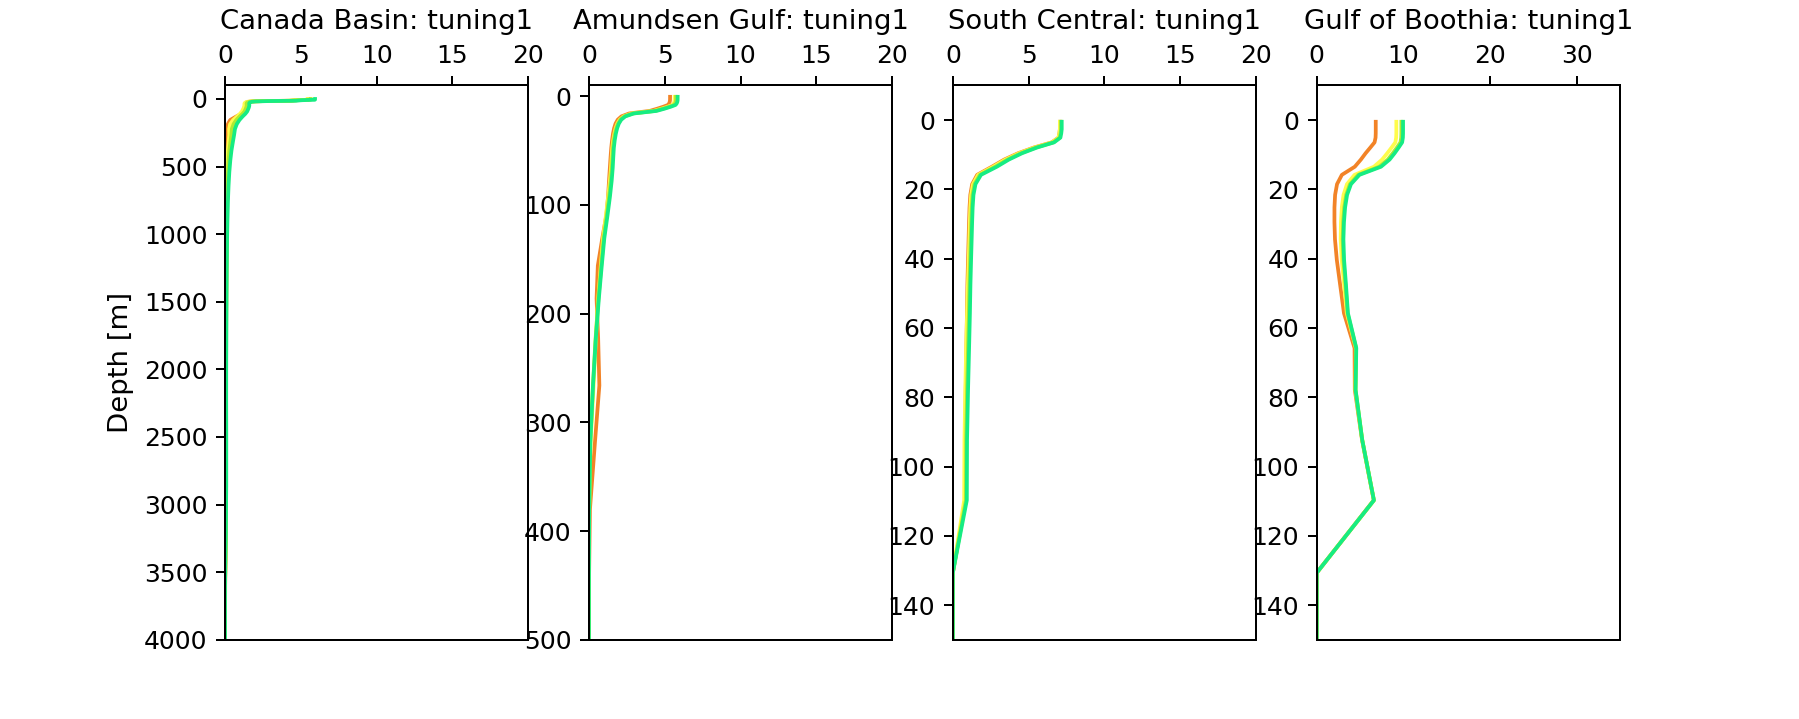

In [15]:
plot_profiles(dmn_tuning1, 'tuning1')

<IPython.core.display.Javascript object>


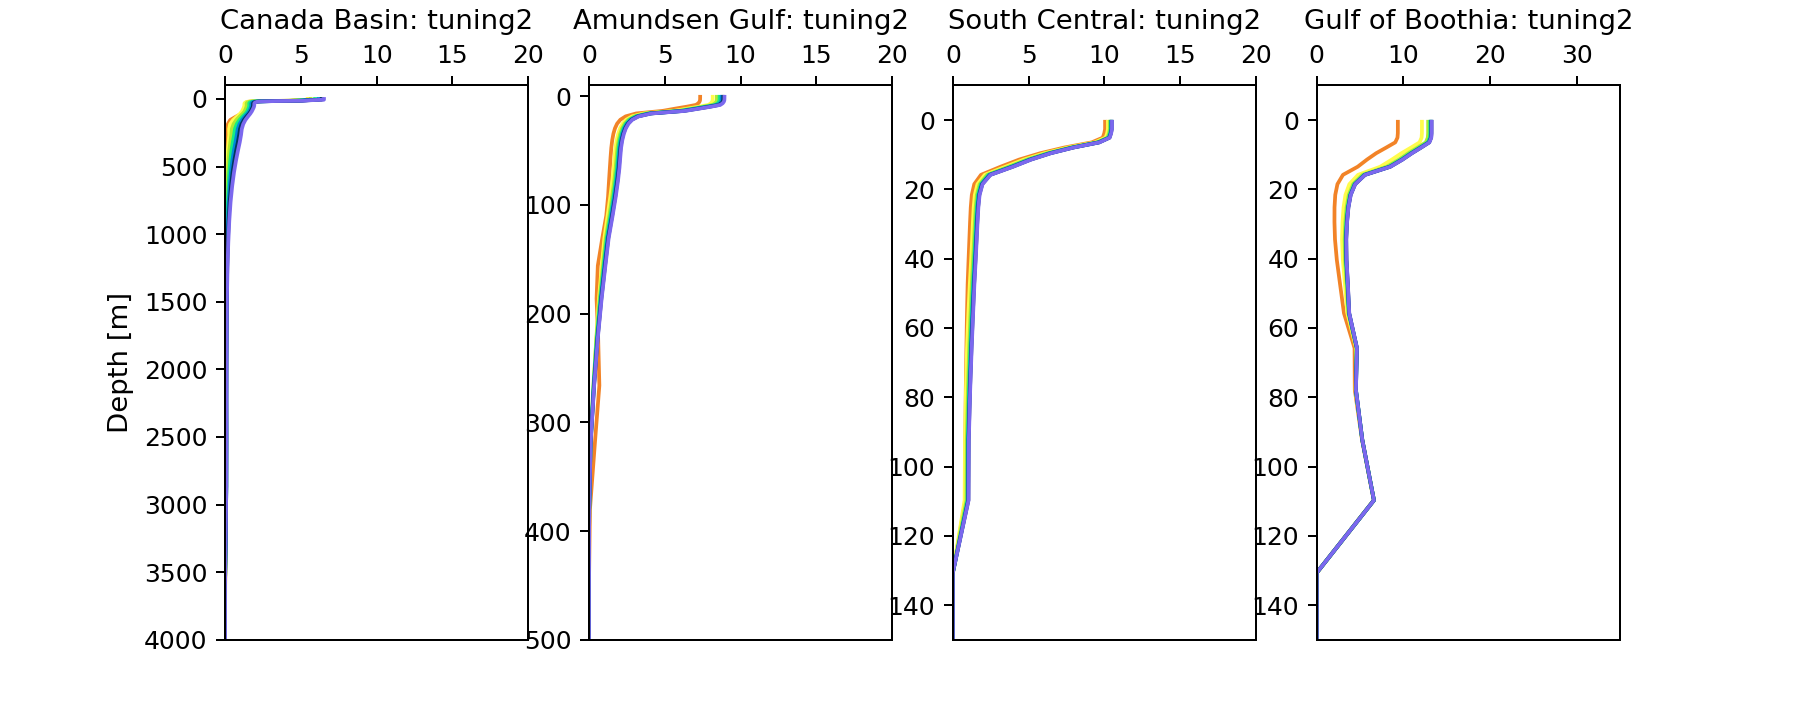

In [14]:
plot_profiles(dmn_tuning2, 'tuning2')

<IPython.core.display.Javascript object>


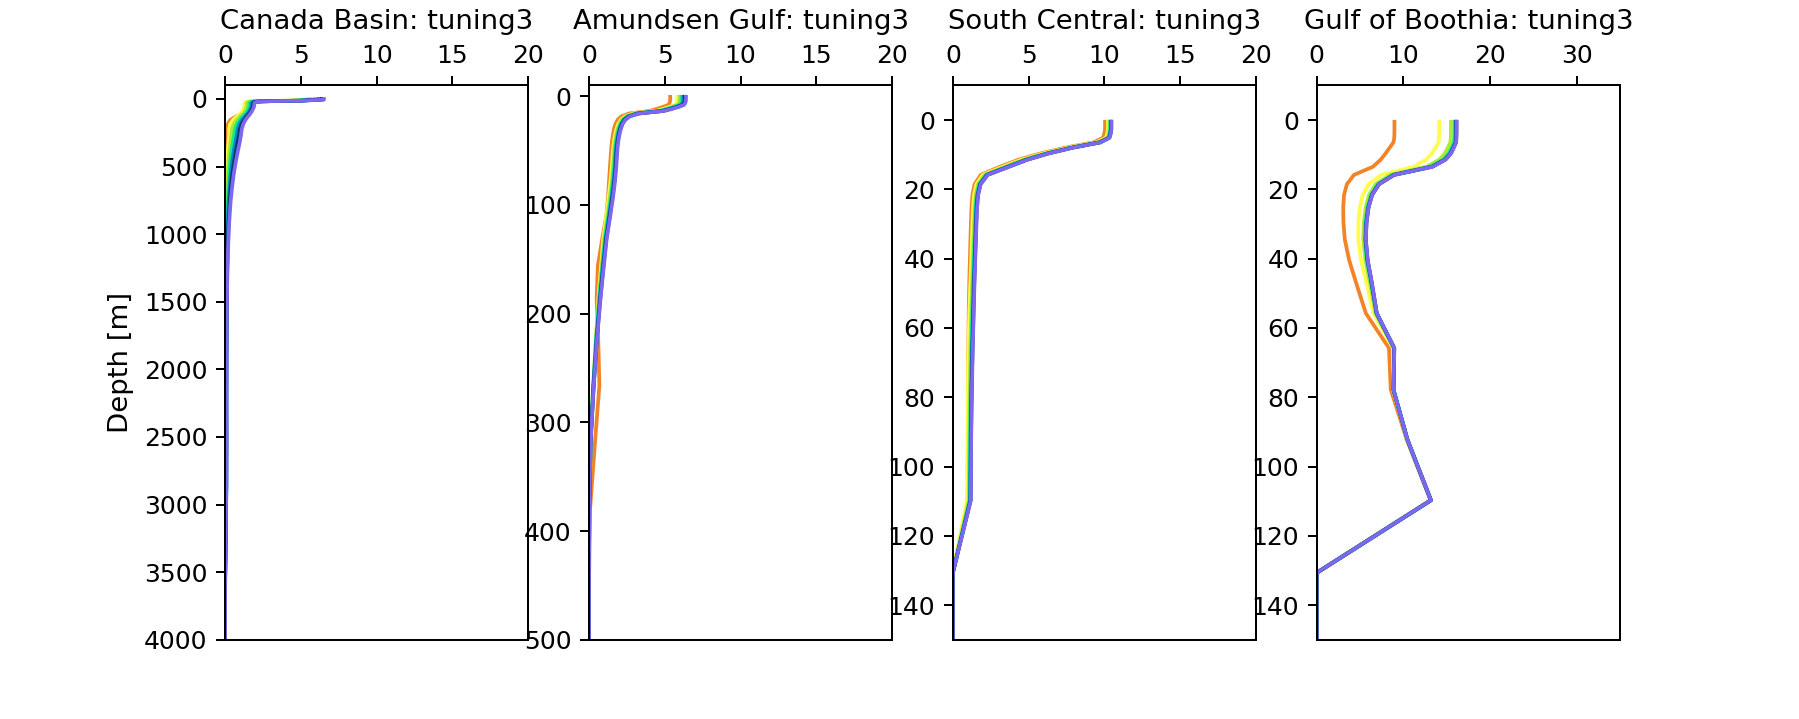

In [15]:
plot_profiles(dmn_tuning3, 'tuning3')

<IPython.core.display.Javascript object>


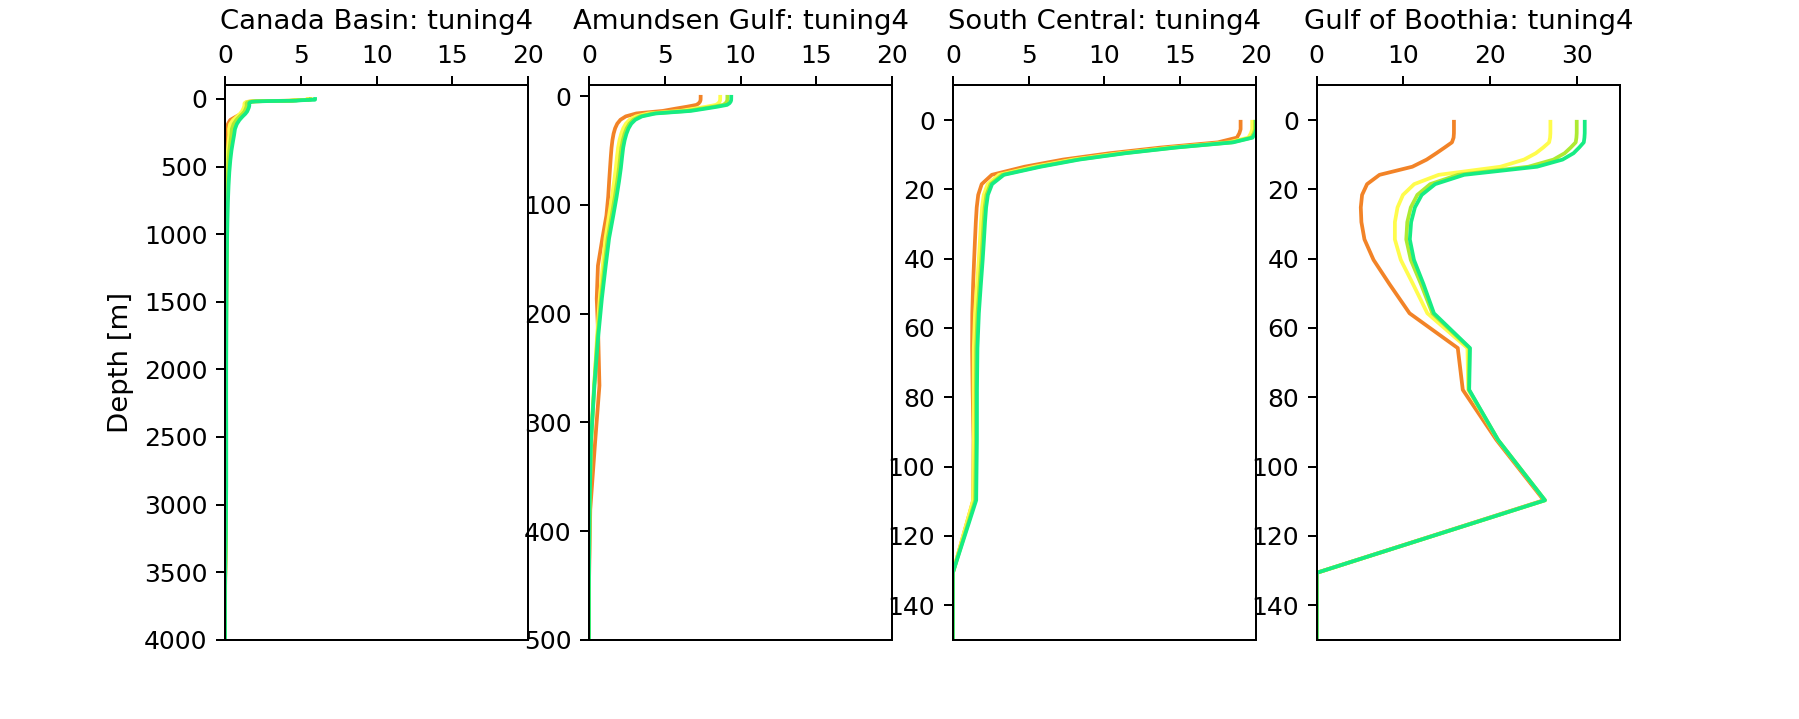

In [16]:
plot_profiles(dmn_tuning4, 'tuning4')

###### Check profiles at station locations:

<IPython.core.display.Javascript object>


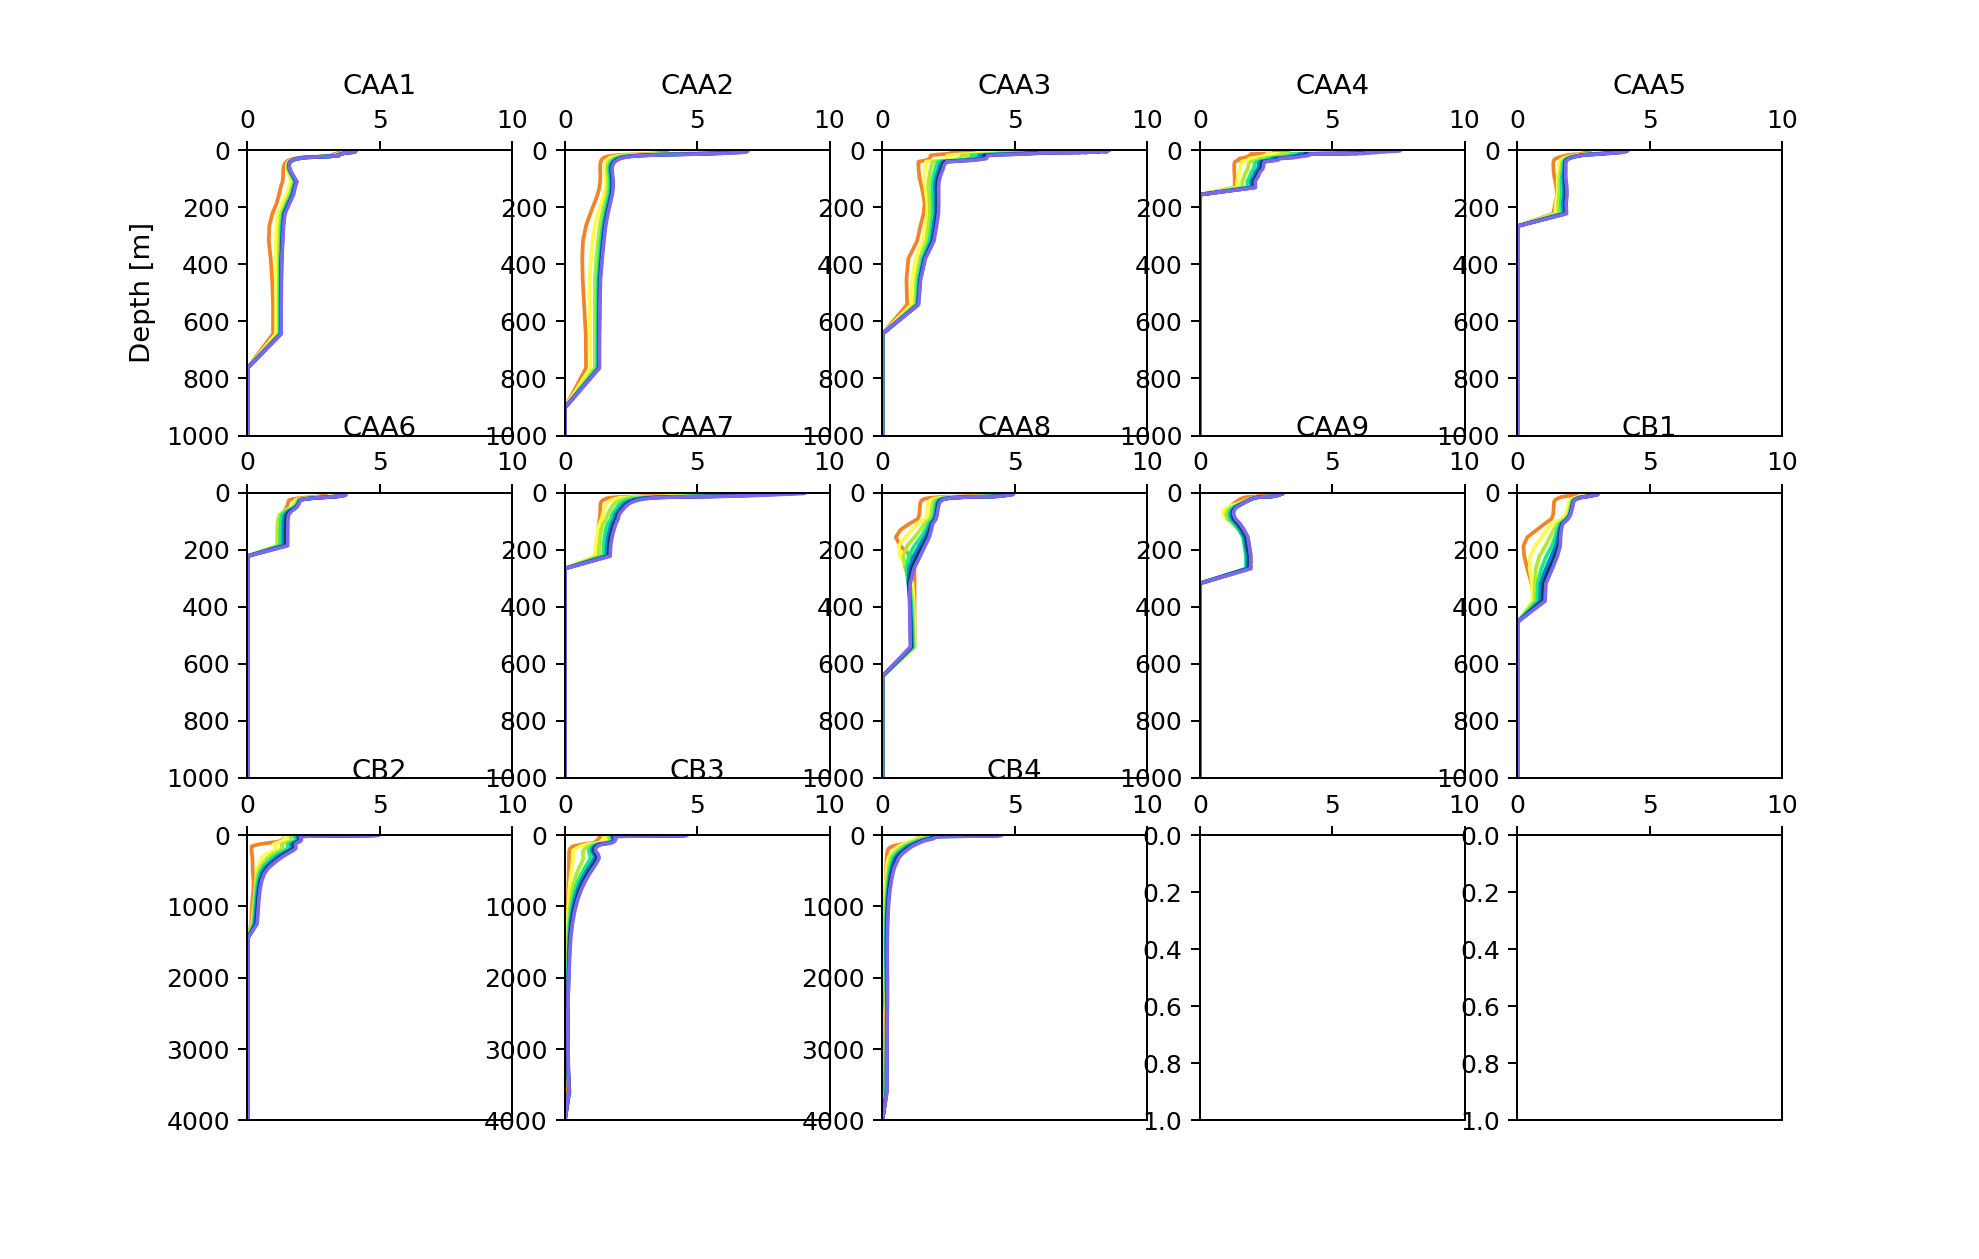

In [81]:
plot_stations(dmn_old)

<IPython.core.display.Javascript object>


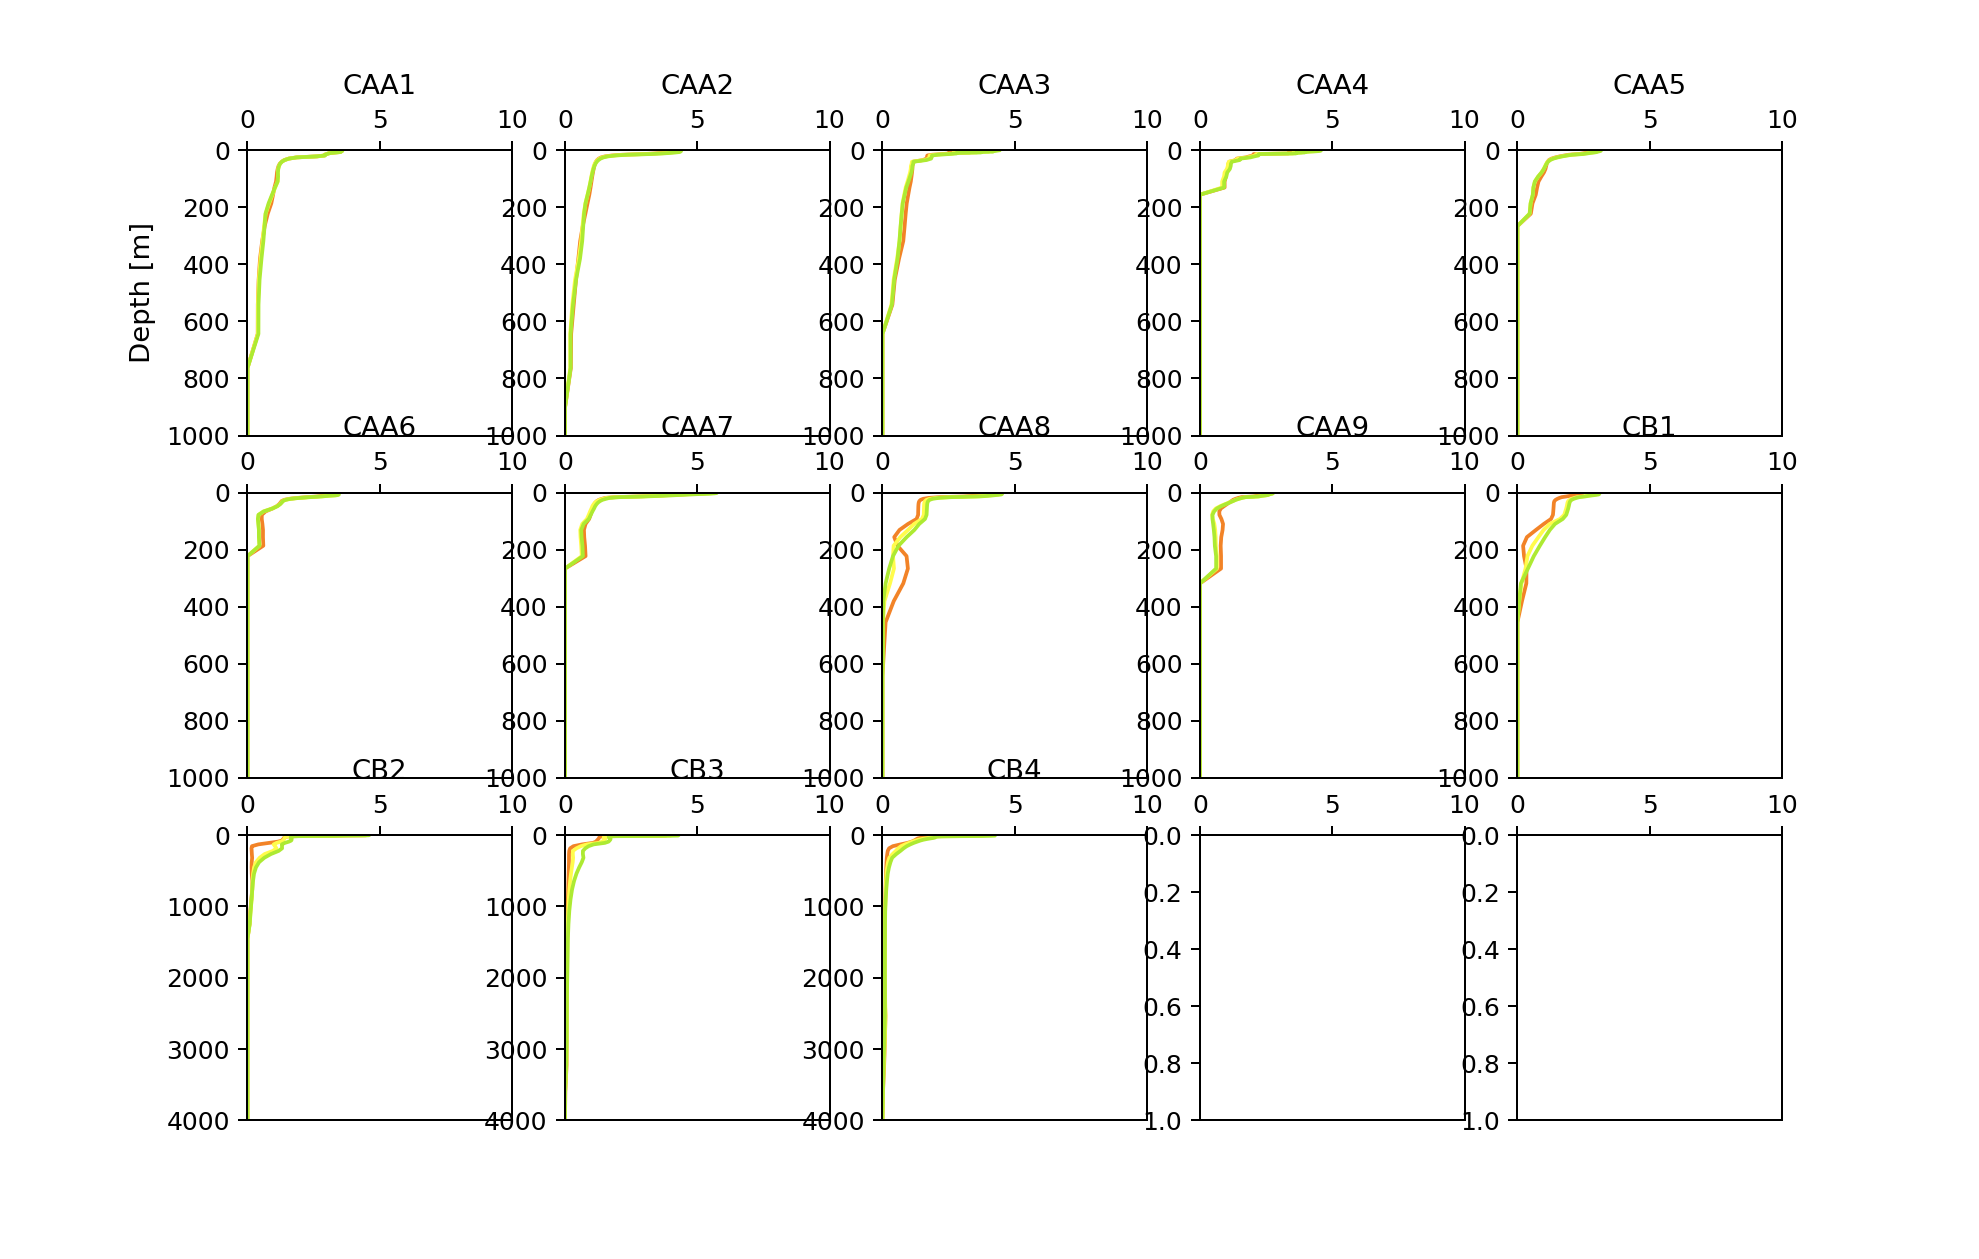

In [18]:
plot_stations(dmn_tuning1)

In [19]:
plot_stations(dmn_tuning2)

<IPython.core.display.Javascript object>

In [ ]:
plot_stations(dmn_tuning3)

In [ ]:
plot_stations(dmn_tuning4)